# Voice Identification


## Install dan Import Library yang dibutuhkan

In [ ]:
!pip install librosa tsfel pandas scikit-learn soundfile
!pip install PyCaret
!apt-get install ffmpeg
from sklearn.neighbors import LocalOutlierFactor
import os
import librosa
import pandas as pd
import numpy as np
import tsfel
import matplotlib.pyplot as plt
import pickle
from tabulate import tabulate
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

## Ekstraksi Fitur Menggunakan TSFEL

TSFEL (**Time Series Feature Extraction Library**) digunakan untuk mengekstrak **fitur numerik** dari sinyal audio. Fitur-fitur ini berguna untuk **machine learning**, misal klasifikasi suara *buka/tutup*.  

---

- Jenis Fitur TSFEL

TSFEL mengekstrak fitur dari 3 domain utama:

1. **Time-domain features**  
   Analisis sinyal langsung di domain waktu.

   - **Mean (Rata-rata)**

   $[
   $mu = $frac{1}{N} sum_{i=1}^{N} x_i
   $]

   - **Standard Deviation (Simpangan baku)**

   $[
   $sigma = $sqrt{\frac{1}{N} \sum_{i=1}^{N} (x_i - \mu)^2}
   $]

   - **Root Mean Square (RMS)**

   $[
   RMS = \sqrt{\frac{1}{N} \sum_{i=1}^{N} x_i^2}
   $]

   - **Skewness (Kemencengan)**

   $[
   $text{Skewness} = $frac{ \frac{1}{N} \sum_{i=1}^{N} (x_i - \mu)^3 }{ \sigma^3 }
   $]

   - **Kurtosis (Keruncingan)**

   $[
   $text{Kurtosis} = $frac{ \frac{1}{N} \sum_{i=1}^{N} (x_i - \mu)^4 }{ \sigma^4 }
   $]

---

2. **Frequency-domain features**  
   Menggunakan transformasi Fourier untuk menganalisis energi di frekuensi.

   - **Spectral Centroid (Titik Pusat Spektrum)**

   $[
   $SC = $frac{ sum_{k=0}^{N-1} f_k $cdot |X(f_k)| }{ $sum_{k=0}^{N-1} |X(f_k)| }
   $]

   - **Spectral Bandwidth (Lebar pita spektrum)**

   $[
   $SB = $sqrt{ \frac{ \sum_{k=0}^{N-1} (f_k - SC)^2 cdot |X(f_k)| }{ $sum_{k=0}^{N-1} |X(f_k)| } }
   $]

   - **Spectral Roll-off (Frekuensi roll-off)**  
     Frekuensi di mana $($alpha\%\) energi spektrum berada di bawahnya.

    $[
    \sum_{f=0}^{f_r} |X(f)| = \alpha \sum_{f=0}^{f_{\text{max}}} |X(f)|
    $]


---

3. **Temporal / Statistical features**  
   Fitur tambahan yang menghitung perubahan atau pola sinyal.

   - **Zero Crossing Rate (ZCR)**

   $[
   $ZCR = $frac{1}{N-1} $sum_{i=1}^{N-1} $mathbf{1}_{\{x_i \cdot x_{i+1} < 0\}}
   $]

   - **Energy (Energi Sinyal)**

   $[
   $E = $sum_{i=1}^{N} x_i^2
   $]

---

In [ ]:
# path ke folder dataset
dataset_path = "/content/drive/MyDrive/data_PSD/datasuara2"

# fitur yang diload hanya spectral, temporal, statistik
cfg = tsfel.get_features_by_domain(["temporal", "spectral", "statistical"])

# untuk menyimpan fitur + label + speaker
data = []

# loop per speaker
for speaker in ["fathan", "other", "zanuar"]:
    speaker_path = os.path.join(dataset_path, speaker)

    for label in ["buka", "tutup"]:
        folder = os.path.join(speaker_path, label)
        for file in os.listdir(folder):
            if file.endswith(".mp3") or file.endswith(".wav"):
                file_path = os.path.join(folder, file)
                print("Memproses:", file_path)

                # Load audio
                signal, sr = librosa.load(file_path, sr=16000)

                # Ekstraksi fitur
                fitur = tsfel.time_series_features_extractor(cfg, signal, fs=sr)

                # Reset index
                fitur = fitur.reset_index(drop=True)

                # Tambahkan label dan speaker
                fitur["label"] = label
                fitur["speaker"] = speaker

                # Simpan
                data.append(fitur)

# Gabungkan semua fitur ke DataFrame
df = pd.concat(data, ignore_index=True)

# Simpan ke CSV
df.to_csv("fitur_audio_tsfel_with_speaker.csv", index=False)
print("Selesai! File fitur: fitur_audio_tsfel.csv")


### Data hasil Ekstraksi fitur menggunakan TSFEL

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/data_PSD/data_suara_csv/fitur_audio_tsfel_with_speaker (1).csv")
df

,0_Absolute energy,0_Area under the curve,0_Autocorrelation,0_Average power,0_Centroid,0_ECDF Percentile Count_0,0_ECDF Percentile Count_1,0_ECDF Percentile_0,0_ECDF Percentile_1,0_ECDF_0,...,0_Wavelet variance_2000.0Hz,0_Wavelet variance_4000.0Hz,0_Wavelet variance_444.44Hz,0_Wavelet variance_500.0Hz,0_Wavelet variance_571.43Hz,0_Wavelet variance_666.67Hz,0_Wavelet variance_800.0Hz,0_Zero crossing rate,label,speaker
0,8.015032,0.010377,11.0,4.840178,0.953609,5299.0,21196.0,-0.000625,0.000256,0.000038,...,0.000053,6.688776e-06,0.003621,0.002992,0.002251,0.001492,0.000838,2764.0,buka,fathan
1,7.515160,0.009869,11.0,4.605054,0.893755,5222.0,20889.0,-0.000813,0.000208,0.000038,...,0.000059,8.850839e-06,0.003217,0.002656,0.002000,0.001329,0.000749,2867.0,buka,fathan
2,9.181598,0.011437,11.0,5.033943,0.928771,5836.0,23347.0,-0.000373,0.000150,0.000034,...,0.000066,8.591820e-06,0.003093,0.002550,0.001929,0.001294,0.000738,3592.0,buka,fathan
3,31.866051,0.025401,11.0,14.591100,1.298860,6988.0,27955.0,-0.000958,0.000497,0.000029,...,0.000197,2.451835e-05,0.008457,0.006949,0.005480,0.004002,0.002553,2565.0,buka,fathan
4,8.968283,0.011917,11.0,6.920306,0.955939,4147.0,16588.0,-0.003200,0.001081,0.000048,...,0.000062,9.500104e-06,0.004448,0.003648,0.002732,0.001801,0.001002,1543.0,buka,fathan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,0.530752,0.002006,10.0,0.491466,0.585359,3456.0,13824.0,-0.000082,0.000108,0.000058,...,0.000002,2.831565e-07,0.000483,0.000370,0.000257,0.000159,0.000085,1695.0,tutup,zanuar
596,0.890495,0.003009,8.0,0.685029,0.667257,4160.0,16640.0,-0.000083,0.000075,0.000048,...,0.000008,4.705061e-07,0.000690,0.000579,0.000440,0.000300,0.000183,1645.0,tutup,zanuar
597,0.844533,0.002530,9.0,0.715744,0.624208,3776.0,15104.0,-0.000048,0.000069,0.000053,...,0.000004,2.912638e-07,0.000781,0.000654,0.000491,0.000322,0.000178,1480.0,tutup,zanuar
598,0.540302,0.001774,9.0,0.482440,0.533942,3584.0,14336.0,-0.000005,0.000004,0.000056,...,0.000003,1.669765e-07,0.000522,0.000416,0.000300,0.000192,0.000106,1380.0,tutup,zanuar


Berdasarkan hal di atas bahwa data yang dihasilkan dari proses ekstraksi menggunakan TSFEL diantaranya terdapat 158 column dengan 600 baris.

### Visualisasi Data

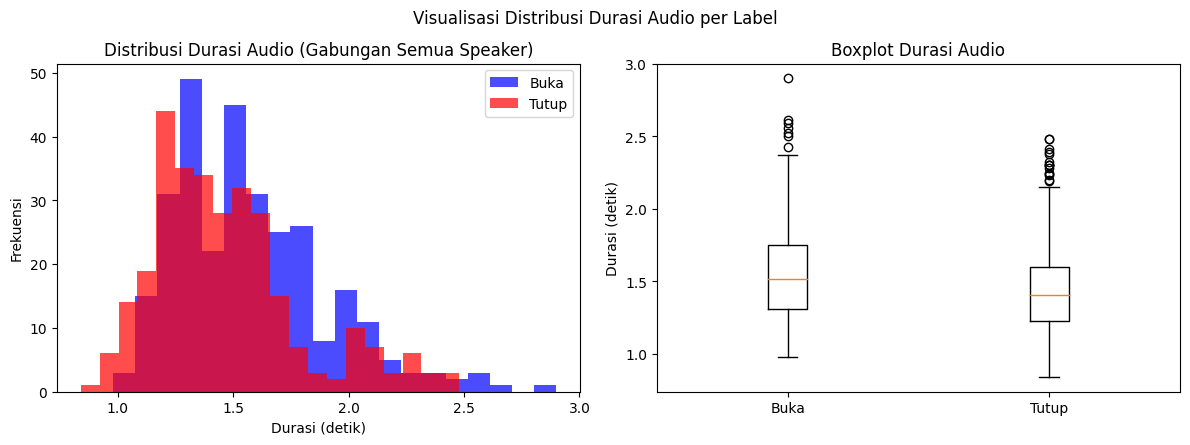

In [ ]:
dataset_path = "/content/drive/MyDrive/data_PSD/datasuara2"
speakers = ["fathan", "other","zanuar"]
folders = ["buka", "tutup"]

# Simpan durasi per label
durations = {"buka": [], "tutup": []}

# Loop per speaker dan label
for speaker in speakers:
    for folder in folders:
        path = os.path.join(dataset_path, speaker, folder)
        if not os.path.exists(path):
            continue

        for filename in os.listdir(path):
            if filename.endswith(".mp3") or filename.endswith(".wav"):
                file_path = os.path.join(path, filename)
                y, sr = librosa.load(file_path, sr=None)
                duration = librosa.get_duration(y=y, sr=sr)
                durations[folder].append(duration)

# Visualisasi
plt.figure(figsize=(12, 8))

# Histogram
plt.subplot(2, 2, 1)
plt.hist(durations["buka"], bins=20, alpha=0.7, label="Buka", color="blue")
plt.hist(durations["tutup"], bins=20, alpha=0.7, label="Tutup", color="red")
plt.xlabel("Durasi (detik)")
plt.ylabel("Frekuensi")
plt.title("Distribusi Durasi Audio (Gabungan Semua Speaker)")
plt.legend()

# Boxplot
plt.subplot(2, 2, 2)
plt.boxplot([durations["buka"], durations["tutup"]], labels=["Buka", "Tutup"])
plt.ylabel("Durasi (detik)")
plt.title("Boxplot Durasi Audio")
plt.suptitle("Visualisasi Distribusi Durasi Audio per Label")
plt.tight_layout()
plt.show()

## Eksplorasi Data atau Data Understanding

### Ukuran Data

In [ ]:
print(df.shape)


(600, 158)


Berdasarkan data diatas ukuran darri data yakni memiliki 400 baris dan 158 kolom

### Tipe data dari setiap fitur

In [ ]:
print(df.dtypes)


0_Absolute energy              float64
0_Area under the curve         float64
0_Autocorrelation              float64
0_Average power                float64
0_Centroid                     float64
                                ...   
0_Wavelet variance_666.67Hz    float64
0_Wavelet variance_800.0Hz     float64
0_Zero crossing rate           float64
label                           object
speaker                         object
Length: 158, dtype: object


### Deteksi Missing Value

In [ ]:
miss_val = pd.DataFrame({
    "Fitur": df.columns,
    "missing_value": df.isna().sum(),
     "data_value_clear": df.shape[0] - df.isna().sum()
})

miss_val

,Fitur,missing_value,data_value_clear
0_Absolute energy,0_Absolute energy,0,600
0_Area under the curve,0_Area under the curve,0,600
0_Autocorrelation,0_Autocorrelation,0,600
0_Average power,0_Average power,0,600
0_Centroid,0_Centroid,0,600
...,...,...,...
0_Wavelet variance_666.67Hz,0_Wavelet variance_666.67Hz,0,600
0_Wavelet variance_800.0Hz,0_Wavelet variance_800.0Hz,0,600
0_Zero crossing rate,0_Zero crossing rate,0,600
label,label,0,600


Berdasarkan hal tersebut dapat disimpulkan bahwa data yang telah dihasilkan tidak terdapat missing value, sehingga data siap untuk digunakan.

### Deteksi Outlier Menggunakan metode LOF

Local Outlier Factor (LOF) adalah sebuah metode untuk mendeteksi outlier dengan cara membandingkan kepadatan suatu data dengan kepadatan data di sekitarnya. Jika sebuah data berada di area yang jauh lebih jarang atau kurang padat dibanding tetangga terdekatnya, maka data tersebut dianggap sebagai outlier. Nilai LOF mendekati 1 menunjukkan bahwa data normal, sedangkan nilai LOF yang jauh lebih besar dari 1 menunjukkan potensi outlier.

In [ ]:
from sklearn.preprocessing import StandardScaler
# load data
data = df.copy()

# Ambil kolom numerik saja
df_fitur_num = data.select_dtypes(include=['float64', 'int64'])

# Normalisasi data dengan StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_fitur_num)

# Inisialisasi LOF
lof = LocalOutlierFactor(n_neighbors=5)

# Fit dan prediksi outlier pada data yang sudah di-scale
pred_outlier = lof.fit_predict(X_scaled)

#menambah kolom -1 = outlier, 1 = normal
data["lof"] = pred_outlier

# jumlah outlier
print("Jumlah outlier:", (data['lof'] == -1).sum())

# Tampilkan data outlier
outliers = data[data['lof'] == -1]
print(outliers[['label','speaker','lof']])



Jumlah outlier: 40
     label speaker  lof
32    buka  fathan   -1
43    buka  fathan   -1
44    buka  fathan   -1
98    buka  fathan   -1
108  tutup  fathan   -1
165  tutup  fathan   -1
167  tutup  fathan   -1
173  tutup  fathan   -1
212   buka   other   -1
235   buka   other   -1
237   buka   other   -1
239   buka   other   -1
240   buka   other   -1
242   buka   other   -1
247   buka   other   -1
259   buka   other   -1
263   buka   other   -1
266   buka   other   -1
268   buka   other   -1
270   buka   other   -1
271   buka   other   -1
277   buka   other   -1
283   buka   other   -1
292   buka   other   -1
296   buka   other   -1
302  tutup   other   -1
327  tutup   other   -1
335  tutup   other   -1
336  tutup   other   -1
337  tutup   other   -1
340  tutup   other   -1
356  tutup   other   -1
373  tutup   other   -1
377  tutup   other   -1
391  tutup   other   -1
394  tutup   other   -1
515  tutup  zanuar   -1
516  tutup  zanuar   -1
518  tutup  zanuar   -1
561  tutup  zanuar   

Berdasarkan hal tersebut terdapat sebanyak 16 baris yang terindikasi outlier.

## Data Prepocessing

### Menghapus data Outlier

In [ ]:
# mengambil indeks dari data outlier
indeks_outlier = data.index[data['lof'] == -1]

# drop data dan reset indeks
data_clean = df.drop(index=indeks_outlier).reset_index(drop=True)

print("jumlah data setelah hapus outlier: ", data_clean.shape[0])

jumlah data setelah hapus outlier:  560


Jadi data 384 merupakan data yang terbebas dari outlier

### Seleksi Fitur Menggunakan Information Gain

Information Gain \(IG\) berasal dari konsep *entropy* dalam teori informasi Shannon.  
Tujuannya adalah memilih fitur yang paling informatif terhadap *label*.

---

**1. Entropy**

$[
H(Y) = - /sum_{i=1}^{n} p(y_i) /log_2 p(y_i)
$]

---

**2. Conditional Entropy**

$[
H(Y|X) = - /sum_{j=1}^{m} p(x_j) /sum_{i=1}^{n} p(y_i|x_j) /log_2 p(y_i|x_j)
$]

---

**3. Information Gain**

$[
IG(X) = H(Y) - H(Y|X)
$]

---

**4. Mutual Information (MI)**  
Sklearn menghitung Information Gain menggunakan:

$[
MI(X, Y) = \sum_{x \in X} \sum_{y \in Y} p(x,y) \log \left( \frac{p(x,y)}{p(x)p(y)} \right)
$]

mutual_info_classif adalah estimator MI untuk data klasifikasi.

In [ ]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
data['label'] = le.fit_transform(data['label'])
data = data_clean.copy()

X = data.drop(columns=['label', 'speaker'])
y = data['label']

IG = mutual_info_classif(X, y, discrete_features = False)

ranking = pd.DataFrame({
    'Fitur' : X.columns,
    'Information_Gain': IG
})

ranking = ranking.sort_values(by='Information_Gain', ascending = False)
ranking = ranking.iloc[0:6]

print(ranking)

hasil_korelasi = ranking['Fitur']

                                        Fitur  Information_Gain
136                         0_Wavelet entropy          0.524760
66                          0_Power bandwidth          0.480911
60                         0_Median frequency          0.422765
20                    0_Fundamental frequency          0.287963
74                         0_Spectral entropy          0.216289
86   0_Spectrogram mean coefficient_1548.39Hz          0.215041


### Mensortir ke Data Utama untuk fitur yang digunakan

In [ ]:
# hasil seleksi fitur
selected_features = ranking['Fitur'].tolist()

# mnerapkan fitur terpilih ke data utama
fitur_selected = data_clean[selected_features + ['speaker', 'label']]

print("Shape data hasil seleksi:", fitur_selected.shape)
fitur_selected.head()

Shape data hasil seleksi: (560, 8)


,0_Wavelet entropy,0_Power bandwidth,0_Median frequency,0_Fundamental frequency,0_Spectral entropy,0_Spectrogram mean coefficient_1548.39Hz,speaker,label
0,1.927934,446.859903,473.429952,137.681159,0.546828,1.380870e-08,fathan,buka
1,1.942045,602.328431,485.294118,138.480392,0.541361,2.092478e-08,fathan,buka
2,1.945652,477.521930,482.456140,137.609649,0.526632,2.401121e-08,fathan,buka
3,1.963304,627.289377,602.106227,141.941392,0.577034,6.154491e-08,fathan,buka
4,1.925708,361.111111,476.080247,154.320988,0.487162,2.283147e-08,fathan,buka


## Modelling

### Split data

In [ ]:
# select data
X = fitur_selected.select_dtypes(include=['float64', 'int64'])
y = (fitur_selected['label'] == "tutup").astype(int)

# split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

### Modelling Menggunakan K-Nearest Neighbours

K-Nearest Neighbors (KNN) adalah salah satu algoritma pembelajaran mesin yang digunakan untuk menyelesaikan masalah klasifikasi maupun regresi. KNN bekerja berdasarkan prinsip kesamaan atau kedekatan antara data. Algoritma ini mengklasifikasikan suatu data baru dengan melihat sejumlah tetangga terdekat (dalam hal ini sebanyak K data) dari data tersebut di ruang fitur.

Dalam proses klasifikasi, ketika sebuah data baru diberikan, KNN akan menghitung jarak antara data baru tersebut dengan seluruh data yang ada dalam dataset pelatihan. Setelah itu, KNN akan memilih K data terdekat berdasarkan jarak tersebut, lalu menentukan kelas mayoritas dari K tetangga itu sebagai prediksi label data baru.

Ketika sebuah data baru diberikan, KNN akan menghitung jarak antara data tersebut dengan semua data pelatihan, menggunakan rumus jarak seperti **Euclidean Distance**:

$$
d(x, y) = \sqrt{ \sum_{i=1}^{n} (x_i - y_i)^2 }
$$

Kemudian, algoritma akan memilih $( K $) data dengan jarak terdekat, lalu menentukan **kelas mayoritas** dari tetangga tersebut sebagai prediksi.

Langkah - Langkah Modelling dengan KNN:

1. Pengumpulan dan persiapan data : Pada kasus ini, sebelum melakukan proses training, data akan di pisah menjadi dua bagian yakni 30% untuk testing dan 70% untuk training. NIlai K yang digunakan sebanyak 6.
2. Pemilihan Parameter K : Jumlah tetangga terdekat yang akan dipertimbangkan saat membuat prediksi. Pemilihan K yang tepat sangat memengaruhi kinerja model.NIlai K yang digunakan sebanyak 6.
3. Proses Prediksi: Hitung jarak (misalnya jarak Euclidean) antara data baru ini dengan SETIAP titik data di set pelatihan. Pilih K titik data dari set pelatihan yang memiliki jarak paling kecil ke data baru tersebut. Lihat kelas dari K tetangga terdekat ini. Kelas yang paling banyak muncul di antara K tetangga tersebut akan menjadi kelas yang diprediksi untuk data baru.

In [ ]:
# normalisasi fitur data train, dan apply ke data test
scaler_knn = MinMaxScaler()
X_train_norm = scaler_knn.fit_transform(X_train)
X_test_norm = scaler_knn.transform(X_test)

# instance model knn
knn = KNeighborsClassifier(n_neighbors=5)
# training
knn.fit(X_train_norm, y_train)
# predict
y_predict_knn = knn.predict(X_test_norm)

acc_knn = accuracy_score(y_test, y_predict_knn)
precision_knn = precision_score(y_test, y_predict_knn)
recall_knn = recall_score(y_test, y_predict_knn)
f1_score_knn = f1_score(y_test, y_predict_knn)

print(f"Akurasi knn: {acc_knn*100:.2f}")
print(f"Precision knn: {precision_knn*100:.2f}")
print(f"Recall knn: {recall_knn*100:.2f}")
print(f"F1-Score knn: {f1_score_knn*100:.2f}")

Akurasi knn: 98.21
Precision knn: 96.55
Recall knn: 100.00
F1-Score knn: 98.25


### Modelling Menggunakan Naive Bayes

Pada saat ini, proses modelling akan menggunakan metode Naive Bayes untuk proses Klasifikasinya.

**Naive Bayes** adalah salah satu metode klasifikasi yang sederhana namun sangat efektif dalam dunia pembelajaran mesin (machine learning). Metode ini bekerja berdasarkan prinsip probabilitas, khususnya Teorema Bayes, yang digunakan untuk memperkirakan kemungkinan suatu data termasuk ke dalam sebuah kelas tertentu.

Ciri khas dari metode ini adalah anggapan bahwa setiap fitur (atau atribut) pada data bersifat saling independen, artinya kemunculan satu fitur tidak dipengaruhi oleh fitur lainnya. Meskipun anggapan ini sering kali tidak sepenuhnya benar dalam kenyataan, pendekatan “naive” ini justru membuat perhitungan menjadi lebih sederhana dan efisien, serta tetap menghasilkan performa yang kompetitif dalam banyak kasus.


Teorema Bayes:

$$
P(C \mid X) = \frac{P(X \mid C) \cdot P(C)}{P(X)}
$$


Keterangan:
- $( P(C \mid X) $): **Posterior** – probabilitas kelas $( C $) diberikan data $( X $)
- $( P(X \mid C) $): **Likelihood** – probabilitas data $( X $) muncul jika kelasnya \( C \)
- $( P(C) $): **Prior** – probabilitas awal kelas $( C $) sebelum melihat data
- $( P(X) $): Probabilitas keseluruhan data $( X $) (konstanta untuk semua kelas)

Langkah - Langkah Pada Modelling:

1. Pada saat Training Model akan membagi dataset menjadi dua bagian yakni 30% datset yang digunakan untuk testing dan 70% data digunakan untuk training.
2. Menghitung Probabilitas Awal
3. Menghitung Persebaran data / Standar Deviasi.
4. Menghitung Distribusi Gaussian.
5. Mnenghitung Posterior.

In [ ]:
# normalisasi fitur data train, dan apply ke data test
scaler_gnb = StandardScaler()
X_train_norm = scaler_gnb.fit_transform(X_train)
X_test_norm = scaler_gnb.transform(X_test)

# instance model Gaussian NB
gnb = GaussianNB()
# training
gnb.fit(X_train_norm, y_train)
# predict
y_predict_gnb = gnb.predict(X_test_norm)

acc_gnb = accuracy_score(y_test, y_predict_gnb)
precision_gnb = precision_score(y_test, y_predict_gnb)
recall_gnb = recall_score(y_test, y_predict_gnb)
f1_score_gnb = f1_score(y_test, y_predict_gnb)

print(f"Akurasi gnb: {acc_gnb*100:.2f}")
print(f"Precision gnb: {precision_gnb*100:.2f}")
print(f"Recall gnb: {recall_gnb*100:.2f}")
print(f"F1-Score gnb: {f1_score_gnb*100:.2f}")

Akurasi gnb: 94.64
Precision gnb: 93.10
Recall gnb: 96.43
F1-Score gnb: 94.74


### Modelling Menggunakan Random Forest

**Random Forest Classifier** adalah sebuah metode klasifikasi yang bekerja dengan menggabungkan banyak pohon keputusan. Setiap pohon dibangun dari potongan data yang berbeda, lalu masing-masing pohon memberikan prediksi terhadap suatu sampel. Prediksi akhir ditentukan berdasarkan hasil voting dari semua pohon, sehingga kelas yang paling banyak dipilih menjadi keputusan model.

Karena mengandalkan banyak pohon sekaligus, Random Forest lebih stabil dan akurat dibanding hanya menggunakan satu pohon keputusan saja. Metode ini mampu mengurangi risiko overfitting, menangani data dengan banyak fitur, serta memberikan informasi mengenai fitur mana yang paling berpengaruh dalam proses klasifikasi. Namun, di sisi lain, Random Forest cenderung lebih lambat dalam pelatihan dan sulit untuk diinterpretasikan karena kompleksitasnya yang tinggi.

---

**Rumus Dasar Voting**

Jika terdapat $( B $) pohon keputusan $( h_b(x) $), maka prediksi akhir adalah:

$$
\hat{y} = \mathrm{mode}\{h_1(x), h_2(x), \dots, h_B(x)\}
$$

Keterangan:
- $( h_b(x) $): prediksi pohon ke-$( b $)  
- $( B $): jumlah total pohon  
- $( \hat{y} $): hasil akhir (kelas mayoritas)

---

**Kriteria Pemisahan (Impurity Measure)**

Untuk memilih split terbaik, digunakan ukuran ketidakmurnian (impurity). Dua yang paling umum:

1. **Gini Index**

$$
Gini(S) = 1 - \sum_{k=1}^{K} p_k^2
$$

2. **Entropy**

$$
Entropy(S) = - \sum_{k=1}^{K} p_k \log_2(p_k)
$$

dengan $( p_k $) adalah proporsi kelas $( k $) dalam node $( S $).

---

**Langkah - Langkah Pada Modelling:**

1. **Membagi Dataset**  
   Biasanya dataset dibagi menjadi 70% untuk *training* dan 30% untuk *testing*.  

2. **Bootstrap Sampling**  
   Dari data *training*, dibuat beberapa subset data dengan pengambilan acak **dengan pengembalian**.  

3. **Bangun Pohon Keputusan**  
   Setiap subset data digunakan untuk membangun satu *Decision Tree*, dengan pemilihan fitur secara acak di tiap node.  

4. **Lakukan Prediksi Voting**  
   Masing-masing pohon memberikan prediksi, lalu hasil akhir ditentukan dengan **mayoritas suara** (*majority vote*).  

5. **Evaluasi Model**  
   Bandingkan prediksi $(\hat{y}$) dengan label sebenarnya menggunakan metrik evaluasi (misalnya *accuracy*).  

---

In [ ]:
# normalisasi fitur data train, dan apply ke data test
scaler_rf = StandardScaler()
X_train_norm = scaler_rf.fit_transform(X_train)
X_test_norm = scaler_rf.transform(X_test)

#instance model Random Forest
rf = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42
)
# training
rf.fit(X_train_norm, y_train)
# predict
y_predict_rf = rf.predict(X_test_norm)

acc_rf = accuracy_score(y_test, y_predict_rf)
precision_rf = precision_score(y_test, y_predict_rf)
recall_rf = recall_score(y_test, y_predict_rf)
f1_score_rf = f1_score(y_test, y_predict_rf)

print(f"Akurasi rf: {acc_rf*100:.2f}")
print(f"Precision rf: {precision_rf*100:.2f}")
print(f"Recall rf: {recall_rf*100:.2f}")
print(f"F1-Score rf: {f1_score_rf*100:.2f}")

Akurasi rf: 97.32
Precision rf: 94.92
Recall rf: 100.00
F1-Score rf: 97.39


## Evaluasi Model

In [ ]:
evaluasi_model = pd.DataFrame({
    "Model" : ["knn", "naive bayes", "random forest"],
    "accuracy": ["98.21", "94.64", "97.32"],
    "precision": ["96.55", "93.10", "94.92"],
    "recall": ["100.00", "96.43" ,"100.00"],
    "f1-score": ["98.25", "94.74" ,"97.39"],
})

evaluasi_model

,Model,accuracy,precision,recall,f1-score
0,knn,98.21,96.55,100.00,98.25
1,naive bayes,94.64,93.10,96.43,94.74
2,random forest,97.32,94.92,100.00,97.39


Berdasarkan hasil dari perhitungan accuracy, precision, recall, dan f1-score model K-NN menjadi model yang lebih baik dibandingkan model lainnya karena setiap hasil metriknya mencapai nilai lebih tinggi dari semua model lainnya.

## Kalsifikasi model untuk deteksi speaker menggunakan KNN

### Model untuk mendeteksi person 1

In [ ]:
# select data
X_person1 = fitur_selected.select_dtypes(include=['float64', 'int64'])
y_person1 = fitur_selected['speaker'].apply(lambda x: 1 if x == 'fathan' else 0)

# split data
X_train, X_test, y_train, y_test = train_test_split(
    X_person1, y_person1, test_size=0.2, random_state=42, stratify=y
)
# normalisasi fitur data train, dan apply ke data test
scaler_knn_person1 = MinMaxScaler()
X_train_norm = scaler_knn_person1.fit_transform(X_train)
X_test_norm = scaler_knn_person1.transform(X_test)

# instance model knn
knn_person1 = KNeighborsClassifier(n_neighbors=5)
# training
knn_person1.fit(X_train_norm, y_train)
# predict
y_predict_knn = knn_person1.predict(X_test_norm)

acc_knn = accuracy_score(y_test, y_predict_knn)
precision_knn = precision_score(y_test, y_predict_knn)
recall_knn = recall_score(y_test, y_predict_knn)
f1_score_knn = f1_score(y_test, y_predict_knn)

print(f"Akurasi knn: {acc_knn*100:.2f}")
print(f"Precision knn: {precision_knn*100:.2f}")
print(f"Recall knn: {recall_knn*100:.2f}")
print(f"F1-Score knn: {f1_score_knn*100:.2f}")


Akurasi knn: 98.21
Precision knn: 97.56
Recall knn: 97.56
F1-Score knn: 97.56


### Model untuk mendeteksi person 2

In [ ]:
# select data
X_person2 = fitur_selected.select_dtypes(include=['float64', 'int64'])
y_person2 = fitur_selected['speaker'].apply(lambda x: 1 if x == 'zanuar' else 0)

# split data
X_train, X_test, y_train, y_test = train_test_split(
    X_person2, y_person2, test_size=0.2, random_state=42, stratify=y
)
# normalisasi fitur data train, dan apply ke data test
scaler_knn_person2 = MinMaxScaler()
X_train_norm = scaler_knn_person2.fit_transform(X_train)
X_test_norm = scaler_knn_person2.transform(X_test)

# instance model knn
knn_person2 = KNeighborsClassifier(n_neighbors=5)
# training
knn_person2.fit(X_train_norm, y_train)
# predict
y_predict_knn = knn_person2.predict(X_test_norm)

acc_knn = accuracy_score(y_test, y_predict_knn)
precision_knn = precision_score(y_test, y_predict_knn)
recall_knn = recall_score(y_test, y_predict_knn)
f1_score_knn = f1_score(y_test, y_predict_knn)

print(f"Akurasi knn: {acc_knn*100:.2f}")
print(f"Precision knn: {precision_knn*100:.2f}")
print(f"Recall knn: {recall_knn*100:.2f}")
print(f"F1-Score knn: {f1_score_knn*100:.2f}")


Akurasi knn: 97.32
Precision knn: 92.50
Recall knn: 100.00
F1-Score knn: 96.10


## Testing menggunakan Data Baru

In [ ]:
def predict_secure_pipeline(file_path, model_fathan, scaler_fathan, model_zanuar, scaler_zanuar, model_command, scaler_command,
    fitur_selected, command_label_map, speaker_threshold=0.8, command_threshold=0.7
):

    # EKSTRAKSI FITUR

    cfg = tsfel.get_features_by_domain()
    signal, sr = librosa.load(file_path, sr=16000)
    fitur = tsfel.time_series_features_extractor(cfg, signal, fs=sr)
    fitur = fitur.reset_index(drop=True)
    # Pilih fitur yang relevan
    X_new = fitur[fitur_selected]

    # fathan model
    X_fathan_scaled = scaler_fathan.transform(X_new)
    prob_is_fathan = model_fathan.predict_proba(X_fathan_scaled)[0][1]

    # 2. Zanuar model
    X_zanuar_scaled = scaler_zanuar.transform(X_new)
    prob_is_zanuar = model_zanuar.predict_proba(X_zanuar_scaled)[0][1]

    identified_speaker = "tidak_diketahui"
    speaker_prob = 0.0

    # kondisi memilih speaker
    if prob_is_fathan >= speaker_threshold:
        identified_speaker = "fathan"
        speaker_prob = prob_is_fathan
    elif prob_is_zanuar >= speaker_threshold:
        identified_speaker = "zanuar"
        speaker_prob = prob_is_zanuar


    if identified_speaker == "tidak_diketahui":
        speaker_prob = max(prob_is_fathan, prob_is_zanuar)
        return "tidak dikenali", 'tidak dikenali', speaker_prob

    # scaler buka atau tutup
    X_command_scaled = scaler_command.transform(X_new)

    # model buka atau tutup
    pred_label_num = model_command.predict(X_command_scaled)[0]
    pred_label_text = command_label_map[pred_label_num]

    # predict model buka atau tutup
    probs_command = model_command.predict_proba(X_command_scaled)[0]
    max_prob_command = np.max(probs_command)

    # jika input suara tidak sesuai
    if max_prob_command < command_threshold:
        pred_label_text = "unknown_command"

    return pred_label_text, identified_speaker, max_prob_command

data_test = "/content/drive/MyDrive/data_PSD/datasuara2/fathan/buka/buka 20.mp3"
label_map = {0: 'buka', 1: 'tutup'}

pred_label, speaker, max_prob = predict_secure_pipeline(
    data_test, knn_person1, scaler_knn_person1, knn_person2, scaler_knn_person2, knn, scaler_knn, selected_features, label_map
)

print("Prediksi label:", pred_label)
print("nama speaker:", speaker)
print("max_prob:", max_prob)

Prediksi label: buka
nama speaker: fathan
max_prob: 1.0


model dapat mendeteksi suara buka atau tutup beserta orang yang menginputkan suaranya.

## Link aplikasi deployment

https://voicedetection23-181.streamlit.app/